In [1]:
from matplotlib import pyplot as plt
import soundfile as sf
from glob import glob
from tqdm import tqdm
import pandas as pd
import librosa
import json
import re

tqdm.pandas()

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=4, progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
data_dir = "/data/asr-research/src/kaldi/data/f88_infer"

In [3]:
filepath = f"{data_dir}/meta.jsonl"
metadata = list(map(json.loads, tqdm(open(filepath).readlines())))
metadata_df = pd.DataFrame(metadata)
metadata_df = metadata_df[["id", "matching_segments"]]
metadata_df = metadata_df[metadata_df.matching_segments.apply(len) > 0]
metadata = None

filepath = f"{data_dir}/ali.jsonl"
alignments = list(map(json.loads, tqdm(open(filepath).readlines())))
alignments_df = pd.DataFrame(alignments)
alignments = None

100%|██████████| 1922728/1922728 [00:17<00:00, 112233.34it/s]


In [5]:
merged_df = pd.merge(alignments_df, metadata_df, on="id", how="inner")
alignments_df, metadata_df = None, None

In [6]:
merged_df = merged_df.explode("matching_segments")

In [7]:
def get_segment_alignments(id, text, audio_filepath, alignments, inter_text):
    text = re.sub(r"\s+", ' ', text).strip()
    inter_text = re.sub(r"\s+", ' ', inter_text).strip()
    
    segments = text.split(inter_text)
    start_index = len(segments[0].split())
    end_index = start_index + len(inter_text.strip().split())

    alignments = alignments[start_index: end_index]
    
    start_time = alignments[0][1]
    end_time = alignments[-1][-1]
    
    return pd.Series([start_time, end_time])

merged_df[["start_time", "end_time"]] = merged_df.progress_apply(
    lambda row: get_segment_alignments(
        id=row['id'],
        text=row['text'],
        audio_filepath=row['audio_filepath'],
        alignments=row['alignments'],
        inter_text=row['matching_segments'],
    ),
    axis=1
)

100%|██████████| 2121414/2121414 [03:20<00:00, 10569.70it/s]


In [8]:
merged_df["duration"] = merged_df.end_time - merged_df.start_time
merged_df.duration.sum() / 3600

<Axes: >

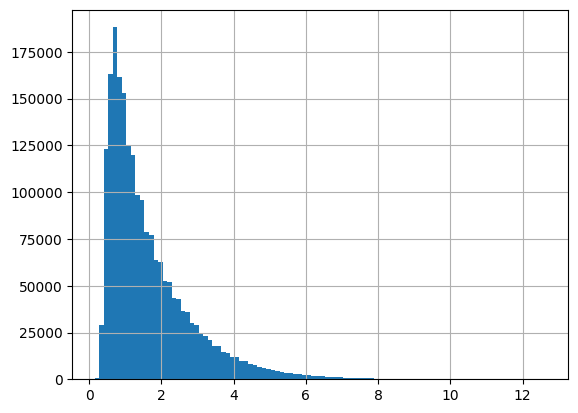

In [10]:
merged_df.duration.hist(bins=100)

In [11]:
merged_df = merged_df.reset_index().drop(columns=["index"])
merged_df = merged_df[
    [
        "audio_filepath", "matching_segments", 
        "start_time", "duration"
        ]
    ].rename(
        columns={
            "matching_segments":"text", 
            "start_time": "offset"
            }
        )

In [13]:
filepath = f"{data_dir}/segments.jsonl"
with open(filepath, "w") as f:
    for index in tqdm(merged_df.index):
        row = merged_df.iloc[index].to_dict()
        json_obj = json.dumps(row, ensure_ascii=False)
        f.write(json_obj + "\n")

100%|██████████| 2121414/2121414 [01:12<00:00, 29319.08it/s]
